In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os

In [110]:
# get the data ready

batch_size = 64
val_cut = 997


# training_data = torch.utils.data.TensorDataset(torch.tensor(np.load('training_data.npy'), dtype=torch.float32), torch.tensor(np.load('training_labels.npy'), dtype=torch.float32))
training_data = torch.utils.data.TensorDataset(torch.tensor(np.zeros((100,19))), torch.tensor(np.zeros((100,500))))
training_generator = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

validation_data = torch.utils.data.TensorDataset(torch.tensor(np.zeros((20,19))), torch.tensor(np.zeros((20,500))))
# validation_data = torch.utils.data.TensorDataset(torch.tensor(np.load('training_data.npy'), dtype=torch.float32), torch.tensor(np.load('training_labels.npy'), dtype=torch.float32))
validation_generator = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)


In [113]:

class buffayCNN(nn.Module):
    def __init__(self):
        super(buffayCNN, self).__init__()
        self.linear1 = nn.Linear(19, 90)
        self.linear2 = nn.Linear(90, 180)
        self.linear3 = nn.Linear(180, 12800*5)
        
        self.conv1 = nn.Conv1d(1, 20, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(20,100, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(100, 150, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(150, 250, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool1d(2)
        
        self.conv5 = nn.Conv1d(250, 150, kernel_size=3, stride=1, padding=1)
        self.maxpool5 = nn.MaxPool1d(2)
        self.conv6 = nn.Conv1d(150, 100, kernel_size=3, stride=1, padding=1)
        self.maxpool6 = nn.MaxPool1d(2)
        self.conv7 = nn.Conv1d(100, 20, kernel_size=3, stride=1, padding=1)
        self.maxpool7 = nn.MaxPool1d(2)
        self.conv8 = nn.Conv1d(20, 1, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))

        x = self.relu((self.conv1(x.reshape((x.shape[0], 1, x.shape[1])))))
        x = self.maxpool1(x)
        
        x = self.relu((self.conv2(x)))
        x = self.maxpool2(x)
        
        x = self.relu((self.conv3(x)))
        x = self.maxpool3(x)
        
        x = self.relu((self.conv4(x)))
        x = self.maxpool4(x)
        
        x = self.relu((self.conv5(x)))
        x = self.maxpool5(x)
        
        x = self.relu((self.conv6(x)))
        x = self.maxpool6(x)
        
        x = self.relu((self.conv7(x)))
        x = self.maxpool7(x)
        
        x = self.relu((self.conv8(x)))
                
        return x.squeeze()

# Create an instance of the SimpleCNN model
model = buffayCNN()

# Print the model architecture
print(model)


buffayCNN(
  (linear1): Linear(in_features=19, out_features=90, bias=True)
  (linear2): Linear(in_features=90, out_features=180, bias=True)
  (linear3): Linear(in_features=180, out_features=64000, bias=True)
  (conv1): Conv1d(1, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(20, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(100, 150, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(150, 250, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(250, 150, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [114]:
model(torch.zeros((10,19))).shape

torch.Size([10, 500])

In [115]:
# build a dierectroy to save the model

training_index = 1

os.makedirs(f'./model_{training_index}', exist_ok=True)
checkpoint_path = f'./model_{training_index}/checkpoint.pth'
# checkpoint_dir = os.path.dirname(checkpoint_path)


In [116]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3

val_losses = []
train_losses = []

best_val_loss = np.inf

for epoch in range(epochs):
    
    temp_train_losses = []
    
    for i, (x, y) in enumerate(training_generator):
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        model.train()
        
        # Forward pass
        y_hat = model(x)
        
        # Compute the loss
        loss = loss_fn(y_hat, y)
        temp_train_losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
    
    train_losses.append(np.mean(np.array(temp_train_losses)))
    
    temp_val_losses = []
    
    for i, (x, y) in enumerate(validation_generator):
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        
        model.eval() 
        
        # Forward pass
        y_hat_val = model(x)
        
        # Compute the loss
        val_loss = loss_fn(y_hat_val, y)
        
        temp_val_losses.append(val_loss.item())
            
    val_losses.append(np.mean(np.array(temp_val_losses)))
    
    if np.mean(np.array(temp_val_losses)) < best_val_loss:
        best_val_loss = np.mean(np.array(temp_val_losses))
        torch.save(model.state_dict(), checkpoint_path)
    
    # Print the loss every 100 iterations
    if i % 100 == 0:
        print(f'Epoch {_}, Iteration {i}, loss: {loss.item()}')



model.train()

buffayCNN(
  (linear1): Linear(in_features=19, out_features=90, bias=True)
  (linear2): Linear(in_features=90, out_features=180, bias=True)
  (linear3): Linear(in_features=180, out_features=64000, bias=True)
  (conv1): Conv1d(1, 20, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(20, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(100, 150, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(150, 250, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(250, 150, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, cei

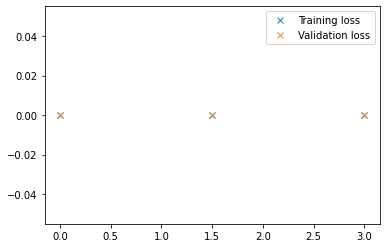

In [127]:
plt.figure()
plt.plot(np.linspace(0,3,len(train_losses)),train_losses,"x", label='Training loss')
plt.plot(np.linspace(0,3,len(train_losses)), val_losses, "x",label='Validation loss')
plt.legend()

In [126]:
train_losses

[0.0, 0.0, 0.0]